### This notebook will take you through the basics of running ODE models in Julia, starting with the example of Michaelis-Menten kinetics.

Firstly, we need to make sure our environment is installed correctly. In this project, the Manifest.toml and Project.toml files should contain all the packages and dependencies needed, so we need to activate the environment and then for the first time running any code in this project, we need to run ```Pkg.instantiate()``` to install all the dependencies.

In [2]:
# run this to ensure the environment is activated and you have access to the packages in Project.toml
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))
# Pkg.instantiate() # if this is the first time using this project, uncomment this line to install the packages

  Activating project at `~/Code/intro_julia_project`


Now the packages are installed, we can load in the ones we will be using in this notebook:

In [3]:
using Catalyst # for defining and simulating reaction networks
using DataFrames # for working with tabular data
using Plots # for plotting
using DifferentialEquations # for solving models

We will use Michaelis-Menten enzyme kinetics as an example. We first need to build the model. In Catalyst.jl, a model is written with the rate followed by the reaction that it is the rate of.

The Michaelis-Menten equation is written as: $$ E + S \xleftrightharpoons[k2]{k1} ES \xrightarrow{k3} P + E $$

There are three reactions in this schematic, governed by rates $k1$, $k2$ and $k3$. We will write these reactions out individually in our Catalyst model:

In [4]:
model = @reaction_network begin
    k1, E + S --> ES
    k2, ES --> E + S
    k3, ES --> P + E
end

Model ##ReactionSystem#235:
Unknowns (4): see unknowns(##ReactionSystem#235)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#235)
  k1
  k2
  k3

We then need to define the conditions for our ODE problem. We must define initial conditions for each species, how long we want the model to run for, and the values of any parameters in our model. We define the initial conditions and parameters as dictionaries, which allows us to denote each species values using the species name, and also edit the parameter by name later on. 

In [29]:
u0 = Dict(:E => 10.0, :S => 50.0, :ES => 0.0, :P => 0.0) # initial conditions
params = Dict(:k1 => 0.01, :k2 => 0.1, :k3 => 0.1) # parameters
tspan = (0.0, 200.0) # time span for the simulation

(0.0, 200.0)

We then need to build our problem. Since we are solving a system of ODEs, our problem type will be an ODEProblem:

In [27]:
prob = ODEProblem(model, u0, tspan, params)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
Initialization status: FULLY_DETERMINED
Non-trivial mass matrix: false
timespan: (0.0, 200.0)
u0: 4-element Vector{Float64}:
 10.0
 50.0
  0.0
  0.0

To solve this we just call ```solve```, and we can simply plot the output using ```plot```:

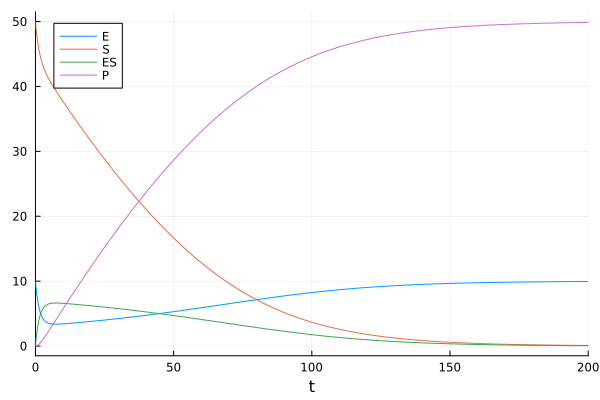

In [28]:
sol = solve(prob, Tsit5()) # Tsit5 is the solver
plot(sol)

Catalyst did a lot of the work for us there, which is nice, but it's important to understand what your model really describes. 

Catalyst has converted our series of reactions into a series of ordinary differential equations (ODEs) and solved them. An ODE describes the change of a species over time: $$ \frac{dX}{dt} = f(X,t). $$

We can directly produce the ODEs from the equations displayed above. We can see the enzyme ($E$) is lost in the first reaction, gained in the second reaction and gained in the last reaction. We write the ODEs according to [mass action kinetics](https://en.wikipedia.org/wiki/Law_of_mass_action), which state that the rate of a reaction is directvly proportional to the product of the concentrations. Therefore, the ODE for $E$ would look like this: $$ \frac{dE}{dt} = - E \cdot S \cdot k1 + ES \cdot k2 + ES \cdot k3. $$

We can follow the same rules for the substrate ($S$), enzyme-substrate complex ($ES$), and product ($P$): $$ \frac{dS}{dt} = - E \cdot S \cdot k1 + ES \cdot k2, $$ $$ \frac{dES}{dt} = E \cdot S \cdot k1 - ES \cdot k2 - ES \cdot k3, $$ $$ \frac{dP}{dt} = ES \cdot k3. $$

We can verify that this is the system we modelled earlier by converting the reaction network to a system of ODEs, this is a good sanity check to make sure our model is written correctly and that it matches the ODEs we just created.

In [6]:
odesys = convert(ODESystem, model)

Model ##ReactionSystem#235:
Equations (4):
  4 standard: see equations(##ReactionSystem#235)
Unknowns (4): see unknowns(##ReactionSystem#235)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#235)
  k1
  k2
  k3

Let's go back to simulating the model. We might be interested in what happens to the system when the final rate increases. We can change this rate and simulate the model with these new parameters:

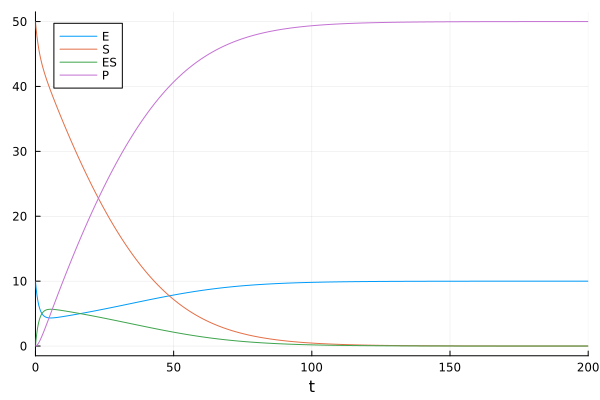

In [34]:
params_new = deepcopy(params) # first make a copy of the original parameters so we don't modify the original parameters and then later forget we've done that 
params_new[:k3] = params[:k3] * 2.0 # double the value of k3

new_prob = ODEProblem(model, u0, tspan, params_new)
new_sol = solve(new_prob, Tsit5())
plot(new_sol)

Using ```plot(sol)``` is useful, but we might want to interrogate the solution in more depth. In this case, we should save our solution as a ```DataFrame```:

In [35]:
df = DataFrame(sol)

Row,timestamp,E(t),S(t),ES(t),P(t)
,Float64,Float64,Float64,Float64,Float64
1,0.0,10.0,50.0,0.0,0.0
2,0.000282826,9.99859,49.9986,0.00141397,1.99961e-8
3,0.00311108,9.98446,49.9845,0.0155361,2.4177e-6
4,0.0313937,9.84498,49.8447,0.155016,0.000244342
5,0.117196,9.44054,49.4372,0.559459,0.00332922
6,0.260357,8.82377,48.8079,1.17623,0.0158359
7,0.464966,8.05334,48.0053,1.94666,0.047992
8,0.749401,7.16398,47.0475,2.83602,0.116463
9,1.13095,6.23276,45.9895,3.76724,0.243274


We can then access each species separately and plot more specifically:

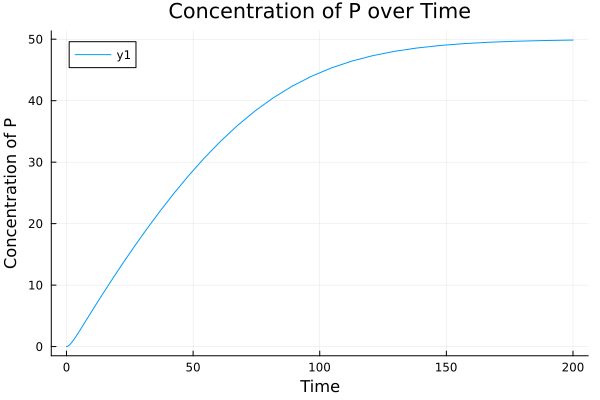

In [41]:
plot(df[!, :timestamp], df[!, "P(t)"], xlabel="Time", ylabel="Concentration of P", title="Concentration of P over Time")

Hopefully you now have a better understanding of how to model dynamic systems in Julia. The folder ```basic_project``` contains the same example we've looked at here, but in a file oriented setup. Whilst this is a really simple example for this kind of setup, it should give an idea of how bigger projects can take shape in different files.

For more information on what was included in this notebook visit the [Catalyst webpages](https://docs.sciml.ai/Catalyst/stable/introduction_to_catalyst/catalyst_for_new_julia_users/), which include a more comprehensive introduction to Julia and using Catalyst.

-------------------

## A note on arrows in Catalyst

##### There is a distinct difference between using --> and => as arrows between rates and reactions. 

##### Using --> will mean that Catalyst uses mass action kinetics to produce the ODEs. 

##### Using => will mean that Catalyst doesn't do any conversions under the hood and your rates will be taken as they are. 

##### See the below example: two models, using different arrow types. They produce the same reactions, but when we go to look at the ODESystem they are significantly different. Keep this in mind when creating other models.

In [ ]:
model1 = @reaction_network begin
    k1, E + S --> ES
    k2, ES --> E + S
    k3, ES --> P + E
end

Model ##ReactionSystem#265:
Unknowns (4): see unknowns(##ReactionSystem#265)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#265)
  k1
  k2
  k3

In [17]:
model2 = @reaction_network begin
    k1, E + S => ES
    k2, ES => E + S
    k3, ES => P + E
end

Model ##ReactionSystem#277:
Unknowns (4): see unknowns(##ReactionSystem#277)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#277)
  k1
  k2
  k3

In [13]:
odesys = convert(ODESystem, model1)

Model ##ReactionSystem#259:
Equations (4):
  4 standard: see equations(##ReactionSystem#259)
Unknowns (4): see unknowns(##ReactionSystem#259)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#259)
  k1
  k2
  k3

In [14]:
odesys = convert(ODESystem, model2)

Model ##ReactionSystem#265:
Equations (4):
  4 standard: see equations(##ReactionSystem#265)
Unknowns (4): see unknowns(##ReactionSystem#265)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#265)
  k1
  k2
  k3

### Here, we can see how you would modify the rates to get the same ODEs with => as using -->

In [ ]:
model3 = @reaction_network begin
    k1 * E * S,     E + S => ES
    k2 * ES,        ES => E + S
    k3 * ES,        ES => P + E
end

Model ##ReactionSystem#271:
Unknowns (4): see unknowns(##ReactionSystem#271)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#271)
  k1
  k2
  k3

In [16]:
odesys = convert(ODESystem, model3)

Model ##ReactionSystem#271:
Equations (4):
  4 standard: see equations(##ReactionSystem#271)
Unknowns (4): see unknowns(##ReactionSystem#271)
  E(t)
  S(t)
  ES(t)
  P(t)
Parameters (3): see parameters(##ReactionSystem#271)
  k1
  k2
  k3